# Kubernetes Scheduler Simulator

## Cluster
    A Kubernetes cluster is a set of nodes that run containerized applications.

In [91]:
import simpy


class Cluster:

    def __init__(self, env, capacity, status=False):
        self.master_node = simpy.Resource(env, capacity=capacity)
        self.node_list = []  # list of nodes in cluster
        self.active_nodes = 0  # initially no nodes are active

    def add_node(self, node):
        self.node_list.append(node)  # insert a node in the cluster

    def get_node_list(self):
        return self.node_list  # returns the list of nodes in the cluster


## Node
    A Node is a worker machine in Kubernetes and may be either a virtual or a
    physical machine, depending on the cluster. Each Node is managed by the
    control plane. A Node can have multiple pods, and the Kubernetes control
    plane automatically handles scheduling the pods across the Nodes in the
    cluster.

In [92]:
import itertools


class Node:

    id_iter = itertools.count()

    def __init__(self, name, memory, cpu, cluster, label=''):
        self.name = name  # name of the node
        self.id = next(Node.id_iter)  # select unique id for each node
        self.num_of_pods = 0  # initially node contains no pod
        self.memory = memory  # RAM resource of the node
        self.cpu = cpu  # CPU resource of the node
        self.score = 0  # the rank of the node (used in scheduling)
        self.port = []  # list of network ports
        self.label = label  # defines some extra feature in the node
        self.pod_list = []  # contains list of running pods in the node
        self.num_pod_history = 0  # total num of pods that the node executed
        self.cluster = cluster  # nodes cluster object
        self.active = False  # initially node is not activated

    def add_pod(self, pod):
        self.pod_list.append(pod)  # bind pod to the node
        self.memory -= pod.memory  # decreasing node memory resource
        self.cpu -= pod.cpu  # decreasing node cpu resource
        pod.is_bind = True  # changing pod state to bind
        pod.assignedNode = self.name  # updating the assigned node of the pod
        self.num_of_pods += 1  # increment the number of pods in the node
        pod.binded = True  # a proof that pod was binded by this node

        # if pod also contains a network port, add in the port list
        if pod.port is not None:
            self.port.append(pod.port)

    def remove_pod(self, pod):
        self.pod_list.remove(pod)  # remove pod from the node
        self.memory += pod.memory  # releasing node memory resource
        self.cpu += pod.cpu  # releasing node cpu resource
        pod.is_bind = False  # changing pod state to unbind
        pod.assignedNode = ''  # removing assigned node name of the pod
        self.num_of_pods -= 1  # decrement the number of pods in the node

        # if pod also contains a network port, release it from the port list
        if pod.port is not None:
            self.port.remove(pod.port)

    def serialize(self):
        return {"Name": self.name,
                "ID": self.id,
                "Num of Pods": self.num_of_pods,
                "Available Memory": self.memory,
                "Available CPU": self.cpu,
                "Score": self.score,
                "Port": self.port}


## Pod
    A pod is the smallest execution unit in Kubernetes. A pod encapsulates
    one or more applications. Pods are ephemeral by nature, if a
    pod (or the node it executes on) fails, Kubernetes can automatically
    create a new replica of that pod to continue operations.

In [93]:
import itertools


class Pod:

    id_iter = itertools.count()

    def __init__(self, name, memory, cpu, plugin, arrivalTime,
                 serviceTime, containerList, nodeName='', nodeSelector='',
                 port=None, schedulerName='default-scheduler'):

        self.name = name  # name of the pod
        self.id = next(Pod.id_iter)  # assigns unique id for each pod
        self.schedulerName = schedulerName  # name of scheduler that pod wants
        self.nodeName = nodeName  # node that the pod prefers to bind
        self.memory = memory  # RAM requirements of the pod
        self.cpu = cpu  # CPU requirements of the pod
        self.is_bind = False  # initially pod is not bind
        self.plugin = plugin  # set of predicates and priorites for the pod
        self.nodeSelector = nodeSelector  # a field to check node label
        self.port = port  # network port requirement of the pod
        self.node = None  # the node object which pod will bind in the future
        self.arrivalTime = arrivalTime  # the time pod entered in the queue
        self.serviceTime = serviceTime  # time to live in the node
        self.container_list = containerList  # list of containers in the pod
        self.schedulingRetries = 0  # retries for scheduling an unassigned pod
        self.assignedNode = ''  # node name that the pod is bind to
        self.wait_in_queue = None  # the time pod waited in the queue
        self.binded = False  # check that pod was binded or not

    def serialize(self):
        return {"Name": self.name,
                "Pod ID": self.id,
                "nodeName": self.nodeName,
                "Memory Requirement": self.memory,
                "CPU Requirement": self.cpu,
                "is_bind": self.is_bind,
                "Port": self.port}


## Container
    Containers are a form of operating system virtualization. A single
    container might be used to run anything from a small microservice
    or software process to a larger application.

In [94]:
class Container:

    def __init__(self, name, image, memory, cpu):
        self.name = name  # name of the container
        self.image = image  # image of the container
        self.memory = memory  # memory requirement
        self.cpu = cpu  # cpu requirement


## Plugin
    A scheduling Profile allows you to configure the different stages of
    scheduling in the kube-scheduler. Each stage is exposed in an extension
    point. Plugins provide scheduling behaviors by implementing one or more
    of these extension points.

In [95]:
class Plugin:

    def __init__(
                self, _pfhp=False, _pfh=False, _pfr=False, _mns=False,
                _nvzc=False, _ndc=False, _mCSIvc=False, _ptnt=False,
                _cvb=False, ssp=False, ipap=False, lrp=False, mrp=False,
                rtcrp=False, bra=False, npapp=False, nap=False, ttp=False,
                ilp=False, ssp_=False, ep=False, epsp=False
                ):

        # Predicates
        self.predicate_list = [_pfhp, _pfh, _pfr, _mns, _nvzc, _ndc,
                               _mCSIvc, _ptnt, _cvb]

        self.predicates_name = ['PodFitsHostPorts', 'PodFitsHost',
                                'PodFitsResources', 'MatchNodeSelector',
                                'NoVolumeZoneConflict', 'noDiskConflict',
                                'MaxCSIVolumeCount', 'PodToleratesNodeTaints',
                                'CheckVolumeBinding']

        # Priorites
        self.priorites_list = [ssp, ipap, lrp, mrp, rtcrp, bra, npapp, nap,
                               ttp, ilp, ssp_, ep, epsp]

        self.priorites_name = ['SelectorSpreadPriority',
                               'InterPodAffinityPriority',
                               'LeastRequestedPriority',
                               'MostRequestedPriority',
                               'RequestedToCapacityRatioPriority',
                               'BalancedResourceAllocation',
                               'NodePreferAvoidPodsPriority',
                               'NodeAffinityPriority',
                               'TaintTolerationPriority',
                               'ImageLocalityPriority',
                               'ServiceSpreadingPriority',
                               'EqualPriority',
                               'EvenPodsSpreadPriority']


## Predicates
    Predicates are hard constraints that can't be violated. It is a
    combination of items provided by the system that users can apply

In [96]:
import random


class Predicates:

    def __init__(self) -> None:
        pass

    def podFitsHostPorts(self, node, pod):
        '''
            Checks if a Node has free ports (the network protocol kind)
            for the Pod ports the Pod is requesting.
        '''

        if pod.port in node.port:
            return False
        else:
            return True

    def podFitsHost(self, node, pod):
        '''
            Checks if a Pod specifies a specific Node by its hostname.
        '''

        if node.name == pod.nodeName:
            return True
        else:
            return False

    def podFitsResources(self, node, pod):
        '''
            Checks if the Node has free resources (eg, CPU and Memory)
            to meet the requirement of the Pod.
        '''

        if node.memory >= pod.memory and node.cpu >= pod.cpu:
            return True
        else:
            return False

    def matchNodeSelector(self, node, pod):
        '''
            Checks if a Pod's Node Selector matches the Node's label(s).
        '''

        if node.label is not None and node.label == pod.nodeSelector:
            return True
        else:
            return False

    def noVolumeZoneConflict(self, node, pod):
        '''
            Evaluate if the Volumes that a Pod requests are available on the
            Node, given the failure zone restrictions for that storage.
        '''

        return random.choice([True, False])

    def noDiskConflict(self, node, pod):
        '''
            Evaluates if a Pod can fit on a Node due to the volumes it
            requests, and those that are already mounted.
        '''

        return random.choice([True, False])

    def maxCSIVolumeCount(self, node, pod):
        '''
            Decides how many CSI volumes should be attached, and whether
            that's over a configured limit.
        '''

        return random.choice([True, False])

    def podToleratesNodeTaints(self, node, pod):
        '''
            checks if a Pod's tolerations can tolerate the Node's taints.
        '''

        return random.choice([True, False])

    def checkVolumeBinding(self, node, pod):
        '''
            Evaluates if a Pod can fit due to the volumes it requests.
            This applies for both bound and unbound PVCs.
            PV: https://kubernetes.io/docs/concepts/storage/persistent-volumes/
        '''

        return random.choice([True, False])


## Priorites
    Priorities are soft constraints. They may be violated, but it gives
    you an idea of how well the constraints are being met or not.

In [97]:
from rich.console import Console
console = Console()


class Priorites:

    def __init__(self):

        self.least_used_node = None
        self.most_used_node = None

    def selectorSpreadPriority():
        '''
        Spreads Pods across hosts, considering Pods that belong to
        the same Service, StatefulSet or ReplicaSet.
        '''

        pass

    def interPodAffinityPriority():
        '''
        Implements preferred inter pod affininity and antiaffinity.
        https://kubernetes.io/docs/concepts/scheduling-eviction/assign-pod-node/#inter-pod-affinity-and-anti-affinity
        '''

        pass

    def leastRequestedPriority(self, parameter):
        '''
        Favors nodes with fewer requested resources. In other words,
        the more Pods that are placed on a Node, and the more resources
        thosePods use, the lower the ranking this policy will give.
        '''

        nodes = parameter['cluster'].get_node_list()
        node_list = []

        for node in nodes:
            node_list.append(node.num_of_pods)

        node_list.sort()

        for node in nodes:
            if node.num_of_pods == node_list[0]:
                self.least_used_node = node
                break

        if self.least_used_node.name == parameter['node'].name:
            if parameter['printing']:
                console.log(":arrow_lower_left:  Least used node ---> {}".format(
                            self.least_used_node.name), style="cyan")

            self.least_used_node.score += 1

    def mostRequestedPriority(self, parameter):
        '''
        Favors nodes with most requested resources. This policy will fit
        the scheduled Pods onto the smallest number of Nodes needed to run
        your overall set of workloads.
        '''

        nodes = parameter['cluster'].get_node_list()
        node_list = []

        for node in nodes:
            node_list.append(node.num_of_pods)

        node_list.sort(reverse=True)

        for node in nodes:
            if node.num_of_pods == node_list[0]:
                self.most_used_node = node
                break

        if self.most_used_node.name == parameter['node'].name:
            if parameter['printing']:
                console.log(":arrow_upper_right:  Most used node ---> {}".format(
                                self.most_used_node.name), style="cyan")

            self.most_used_node.score += 1

    def requestedToCapacityRatioPriority():
        '''
        Creates a requestedToCapacity based ResourceAllocationPriority
        using default resource scoring function shape.
        '''

        pass

    def balancedResourceAllocation():
        '''
        Favors nodes with balanced resource usage.
        '''

        pass

    def nodePreferAvoidPodsPriority():
        '''
        Prioritizes nodes according to the node annotation
        scheduler.alpha.kubernetes.io/preferAvoidPods. You can use this
        to hint that two different Pods shouldn't run on the same Node.
        '''

        pass

    def nodeAffinityPriority():
        '''
        Prioritizes nodes according to node affinity scheduling preferences
        indicated in PreferredDuringSchedulingIgnoredDuringExecution.
        You can read more about this in Assigning Pods to Nodes.
        '''

        pass

    def taintTolerationPriority():
        '''
        Prepares the priority list for all the nodes, based on the number of
        intolerable taints on the node. This policy adjusts a node's rank
        taking that list into account.
        '''

        pass

    def imageLocalityPriority(self, parameter):
        '''
        Favors nodes that already have the container images for that
        Pod cached locally.
        '''

        for pod_list in parameter['node'].pod_list:
            for container_list in parameter['pod'].container_list:
                for pod_container_list in pod_list.container_list:
                    if container_list.image == pod_container_list.image:
                        parameter['node'].score += 1
                        if parameter['printing']:
                            console.log(":cd: Image locality Found ---> {}".format(
                            parameter['node'].name), style="cyan")
                        return

    def serviceSpreadingPriority():
        '''
        For a given Service, this policy aims to make sure that the Pods for
        the Service run on different nodes. It favours scheduling onto nodes
        that don't have Pods for the service already assigned there.
        The overall outcome is that the Service becomes more resilient to
        a single Node failure.
        '''

        pass

    def equalPriority():
        '''
        Gives an equal weight of one to all nodes.
        '''

        pass

    def evenPodsSpreadPriority():
        '''
        Implements preferred pod topology spread constraints.
        '''

        pass


## Kubescheduler
    The Kubernetes scheduler is a control plane process which assigns Pods to
    Nodes. The scheduler determines which Nodes are valid placements for each
    Pod in the scheduling queue according to constraints and available
    resources. The scheduler then ranks each valid Node and binds the Pod to
    a suitable Node.

In [98]:
from rich.console import Console
from rich.table import Table
from rich.traceback import install
import logging
install()  # creates a better readable traceback


logging.basicConfig(filename='test.log', level=logging.DEBUG,
                    format='%(asctime)s:%(levelname)s:%(message)s')


class Kubescheduler(Predicates, Priorites):

    def __init__(self, name='Kubescheduler'):
        super().__init__()
        self.name = name  # name of the scheduler
        self.feasible_nodes = []  # list of feasible nodes for the pod
        self.selected_node = None  # final selected node for the pod

        self.predicate_methods = [self.podFitsHostPorts, self.podFitsHost,
                                  self.podFitsResources,
                                  self.matchNodeSelector,
                                  self.noVolumeZoneConflict,
                                  self.noDiskConflict,
                                  self.maxCSIVolumeCount,
                                  self.podToleratesNodeTaints,
                                  self.checkVolumeBinding]

        self.priorites_methods = [self.selectorSpreadPriority,
                                  self.interPodAffinityPriority,
                                  self.leastRequestedPriority,
                                  self.mostRequestedPriority,
                                  self.requestedToCapacityRatioPriority,
                                  self.balancedResourceAllocation,
                                  self.nodePreferAvoidPodsPriority,
                                  self.nodeAffinityPriority,
                                  self.taintTolerationPriority,
                                  self.imageLocalityPriority,
                                  self.serviceSpreadingPriority,
                                  self.equalPriority,
                                  self.evenPodsSpreadPriority]

    def scheduling_cycle(self, cluster, pod, simTime, console, printing):
        nodes = cluster.get_node_list()  # list of all the nodes
        global node_passed  # check to add node in feasible list
        node_passed = False  # initially node is not feasible

        for node in nodes:
            priority_parameters = {'cluster': cluster,
                                   'node': node, 'pod': pod,
                                   'printing': printing}
            '''
            This loop finds the number of feasible node(s)
            for the pod by applying a set of predicates.
            This Process is called FILTERING.
            '''
            for pred in range(len(pod.plugin.predicate_list)):
                # checks whether plugin is ON/OFF
                if pod.plugin.predicate_list[pred]:
                    if (self.predicate_methods[pred](node, pod)):
                        if printing:
                            console.log(":thumbs_up: {} ---> {}".format(
                                    pod.plugin.predicates_name[pred],
                                    node.name), style="cyan")
                        node_passed = True
                    else:
                        if printing:
                            console.log(":thumbs_down: {} ---> {}".format(
                                    pod.plugin.predicates_name[pred],
                                    node.name), style="cyan")
                        node_passed = False
                        break

            if node_passed:
                self.feasible_nodes.append(node)

            '''
            This loop apply a set of priorites on each node.
            This Process is called SCORING.
            '''
            for pri in range(len(pod.plugin.priorites_list)):
                if pod.plugin.priorites_list[pri]:
                    self.priorites_methods[pri](priority_parameters)

        # check that feasible nodes list is not empty
        if len(self.feasible_nodes) > 0:

            # sort the nodes on the basis of their score
            self.feasible_nodes.sort(key=lambda x: x.score, reverse=True)

            # select the node with the highest score
            self.selected_node = self.feasible_nodes[0]
            self.selected_node.add_pod(pod)  # add the pod to the selected node
            pod.node = self.selected_node  # bind pod to the selected node
            if self.selected_node.active is False:
                cluster.active_nodes += 1
                self.selected_node.active = True  # activating node

            logging.info(' \"Selected node: {}\"\n'.format(
                         self.selected_node.name))

            if printing:
                console.log("\n---> Selected node = {} :hourglass: [{} seconds]\n".format(
                        self.selected_node.name, simTime), style="bold green")

        else:  # no feasible node found for the pod
            logging.info(' \"No feasible node found\"\n')
            if printing:
                console.log("\n---> No feasible node found :hourglass: [{} seconds]".format(simTime), style="bold red")

        table = Table(title="Node Description")

        table.add_column("Name", justify="center", style="cyan")
        table.add_column("ID", justify="center", style="magenta")
        table.add_column("Num of Pods", justify="center", style="green")
        table.add_column("Memory", justify="center", style="cyan")
        table.add_column("CPU", justify="center", style="magenta")
        table.add_column("Score", justify="center", style="green")
        table.add_column("Port", justify="center", style="cyan")

        for node in nodes:
            # table.add_row(node.name, str(node.id), str(node.num_of_pods),
            #               str(node.memory), str(node.cpu), str(node.score),
            #               str(node.port))

            node.score = 0  # clear the node score for the next pod scheduling

        # console.log(table)


## Simulator Application

[19:02:06] ╔══════════════════════════════════════════════════════════════╗ ]8;id=890231;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=579147;file:///tmp/ipykernel_69257/2937359974.py#439\439]8;;\
           ║                       Start Simulation                       ║                  
           ╚══════════════════════════════════════════════════════════════╝


Working...:   0%|                                         | 0/4 [00:00<?, ?it/s]

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║             Experiment Done [Jobs: 10, Nodes: 2]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║             Experiment Done [Jobs: 10, Nodes: 4]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║             Experiment Done [Jobs: 10, Nodes: 8]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 10, Nodes: 16]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 10, Nodes: 32]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 10, Nodes: 64]             ║                  
           ╚══════════════════════════════════════════════════════════════╝


Working...:  25%|████████▎                        | 1/4 [00:00<00:00,  4.84it/s]

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║             Experiment Done [Jobs: 50, Nodes: 2]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║             Experiment Done [Jobs: 50, Nodes: 4]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║             Experiment Done [Jobs: 50, Nodes: 8]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 50, Nodes: 16]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 50, Nodes: 32]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 50, Nodes: 64]             ║                  
           ╚══════════════════════════════════════════════════════════════╝


Working...:  50%|████████████████▌                | 2/4 [00:00<00:00,  2.51it/s]

[19:02:07] ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 100, Nodes: 2]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 100, Nodes: 4]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 100, Nodes: 8]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 100, Nodes: 16]            ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 100, Nodes: 32]            ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 100, Nodes: 64]            ║                  
           ╚══════════════════════════════════════════════════════════════╝


Working...:  75%|████████████████████████▊        | 3/4 [00:01<00:00,  1.55it/s]

[19:02:08] ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 200, Nodes: 2]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 200, Nodes: 4]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 200, Nodes: 8]             ║                  
           ╚══════════════════════════════════════════════════════════════╝

[19:02:09] ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 200, Nodes: 16]            ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 200, Nodes: 32]            ║                  
           ╚══════════════════════════════════════════════════════════════╝

           ╔══════════════════════════════════════════════════════════════╗ ]8;id=326948;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=313228;file:///tmp/ipykernel_69257/2937359974.py#477\477]8;;\
           ║            Experiment Done [Jobs: 200, Nodes: 64]            ║                  
           ╚══════════════════════════════════════════════════════════════╝

Working...: 100%|█████████████████████████████████| 4/4 [00:03<00:00,  1.25it/s]


           ╔══════════════════════════════════════════════════════════════╗ ]8;id=726198;file:///tmp/ipykernel_69257/2937359974.py\2937359974.py]8;;\:]8;id=314117;file:///tmp/ipykernel_69257/2937359974.py#611\611]8;;\
           ║                       Simulation Ended                       ║                  
           ╚══════════════════════════════════════════════════════════════╝

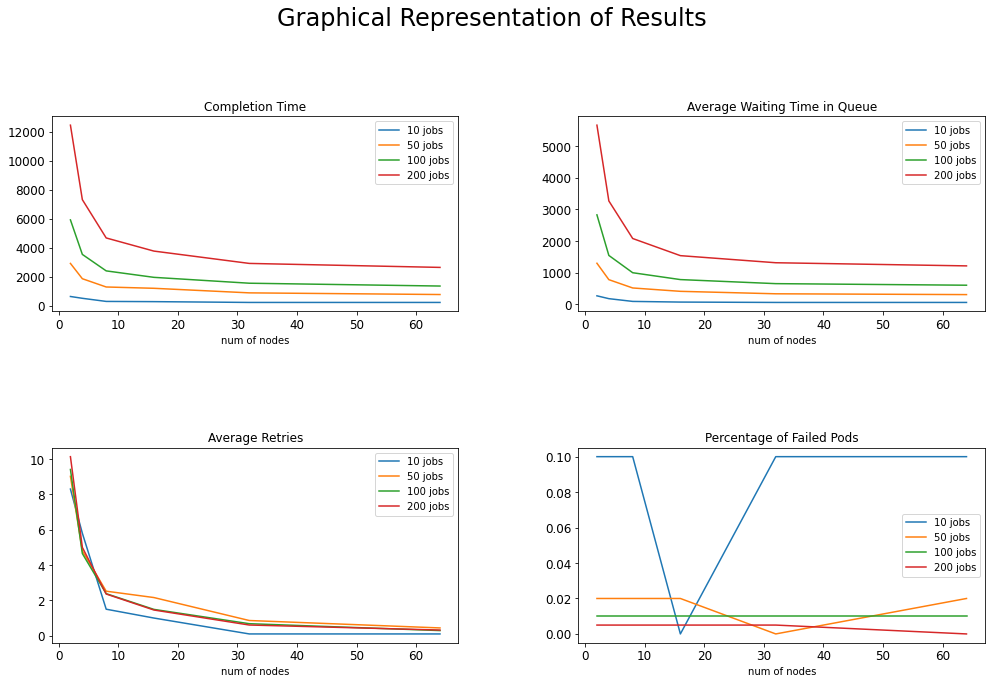

In [99]:
from rich.console import Console
from rich.table import Table
from rich.traceback import install
from rich.markdown import Markdown
from rich.progress import track
from random import seed
from random import randint
from numpy import random
from functools import reduce
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import simpy.rt
import queue
import logging
import yaml
import glob
import os
install()  # creates a better readable traceback


table = Table(title="Pod Description")

table.add_column("Name", justify="center", style="cyan")
table.add_column("ID", justify="center", style="magenta")
table.add_column("Node Assigned", justify="center", style="green")
table.add_column("Memory Req", justify="center", style="cyan")
table.add_column("CPU Req", justify="center", style="magenta")
table.add_column("Bind", justify="center", style="green")
table.add_column("Port", justify="center", style="cyan")
table.add_column("Arrival Time", justify="center", style="magenta")
table.add_column("Service Time", justify="center", style="green")

node_table = Table(title="Final Node Description")

node_table.add_column("Name", justify="center", style="cyan")
node_table.add_column("ID", justify="center", style="magenta")
node_table.add_column("Num of Pods", justify="center", style="green")
node_table.add_column("Memory", justify="center", style="cyan")
node_table.add_column("CPU", justify="center", style="magenta")
node_table.add_column("Score", justify="center", style="green")
node_table.add_column("Port", justify="center", style="cyan")

console = Console(record=True)

'''
creates a test.log file which contains the result of the experiment performed.
'''
logging.basicConfig(filename='test.log', level=logging.DEBUG,
                    format='%(asctime)s:%(levelname)s:%(message)s')

_NODES = []  # contains list of all the working nodes in the cluster
_PODS = []  # contains list of all the pods created
_POD_QUEUE = queue.Queue()  # pods arrive in a FIFO queue

index = []  # list of simulation time when pod is bind to a node
pd_pods = []  # list of names of all the pods
pd_status = []  # boolean list for the bind/unbind status of pod


def cluster_generator(env, num_mNode, num_node, jobs, jobType, printing,
                      seed, ref_node_mem, ref_node_cpu, cluster_yield_time,
                      sched_yield_time, plugin_csv):

    if printing:
        console.log("---> Start Cluster :hourglass: [{} seconds]\n".format(
                env.now), style="bold green")
    logging.info(' Start Cluster at {} seconds\n'.format(env.now))

    cluster = Cluster(env, num_mNode)  # create cluster with master node(s)
    request = cluster.master_node.request()  # access master node resource
    yield request

    '''
    Tell the simulation enviroment to run the
    create_nodes activity generator.
    '''
    nodes = env.process(create_nodes_generator(env, cluster, num_node, printing))
    yield nodes
    if printing:
        console.log("---> Nodes created successfully :hourglass: [{} seconds]\n".format(
                env.now), style="blue bold")
    logging.info(' Nodes created successfully at {} seconds\n'.format(env.now))

    '''
    Tell the simulation enviroment to run the create_pods activity generator.
    The method create pods and add them in a FIFO queue.
    '''
    if jobType == 'yaml':
        pods = env.process(create_pods_yaml_generator(env, printing))
    elif jobType == 'csv':
        pods = env.process(create_pods_csv_generator(env, jobs, printing,
                                                     seed, ref_node_mem,
                                                     ref_node_cpu, plugin_csv,
                                                     num_node))
    yield pods

    # Keep doing this indefinitely (whilst the program's running)
    while True:

        # wait before getting next pod
        yield env.timeout(cluster_yield_time)

        # if the queue is not empty
        if (_POD_QUEUE.empty() is False):

            pod = _POD_QUEUE.get()  # pop the pod from the queue
            pod.wait_in_queue = env.now - pod.arrivalTime

            '''
            Tell the simulation enviroment to run the
            kubescheduler activity generator
            '''
            scheduler = env.process(kubescheduler_generator(env, cluster, pod,
                                                            printing, sched_yield_time))

            '''
            Tell the simulation enviroment to run the
            drop pod activity generator
            '''
            removePod = env.process(drop_pod_generator(env, pod, cluster, printing))

        yield scheduler | removePod  # Either one process finished

        # Stop the cluster if the following processes finished
        if scheduler.triggered and removePod.triggered:
            break

    cluster.master_node.release(request)  # release resources


def create_nodes_generator(env, cluster, num_node, printing):
    '''
    This function creates all working nodes described in the input file.
    '''
    if printing:
        console.log("===> Creating Nodes ", style="bold blue")

    for filename in glob.glob('src/*.yaml'):  # load YAML file from src
        with open(os.path.join(os.getcwd(), filename), 'r') as stream:
            try:
                input = yaml.safe_load(stream)  # loads data from input file
                if input['cluster']['wNode_creationType'] == 'auto':
                    memory = input['cluster']['autoNode']['memory']
                    cpu = input['cluster']['autoNode']['cpu']
                    label = input['cluster']['autoNode']['label']
                    creationTime = input['cluster']['wNode_creationTime']
                    name = 'n'
                    for i in range(num_node):
                        node = Node(name+str(i), memory, cpu, cluster, label)  # create node
                        cluster.add_node(node)  # add node to the cluster
                        _NODES.append(node)

                    yield env.timeout(creationTime)

                elif input['cluster']['wNode_creationType'] == 'manual':
                    for i in range(num_node):
                        name = input['cluster']['node'][i]['name']
                        memory = input['cluster']['node'][i]['memory']
                        cpu = input['cluster']['node'][i]['cpu']
                        label = input['cluster']['node'][i]['label']
                        creationTime = input['cluster']['wNode_creationTime']

                        node = Node(name, memory, cpu, cluster, label)  # create node
                        cluster.add_node(node)  # add node to the cluster
                        _NODES.append(node)

                        yield env.timeout(creationTime)

            except yaml.YAMLError as exc:
                print(exc)


def create_pods_yaml_generator(env, printing):
    '''
    This function creates all the pods described in the input (YAML) file.
    '''
    if printing:
        console.log("===> Creating Pods ", style="bold blue")

    pod_data = {}  # contains pod info described in the input file

    for filename in glob.glob('src/*.yaml'):
        with open(os.path.join(os.getcwd(), filename), 'r') as stream:
            try:
                input = yaml.safe_load(stream)
                for i in range(len(input['pods']['pod'])):
                    pod_name = input['pods']['pod'][i]['name']
                    plugin = input['pods']['pod'][i]['plugin']
                    arrivalRate = input['pods']['pod'][i]['arrivalRate']
                    serviceTime = input['pods']['pod'][i]['serviceTime']

                    pod_data[pod_name] = [plugin, arrivalRate, serviceTime]

            except yaml.YAMLError as exc:
                print(exc)

    container_list = []  # list of containers in the pod

    for filename in sorted(glob.glob('pods/*.yaml')):
        with open(os.path.join(os.getcwd(), filename), 'r') as stream:
            try:
                pod_file = yaml.safe_load(stream)
                name = pod_file['metadata']['name']

                if name in pod_data:
                    yield env.timeout(pod_data[name][1])
                    logging.info(' {} entered the queue at {} seconds \n'.format(
                                 name, env.now))
                    if printing:
                        console.log('---> {} entered the queue at {} seconds'.format(
                                name, env.now))
                    schedulerName = pod_file['spec']['schedulerName']
                    nodeName = pod_file['spec']['nodeName']
                    nodeSelector = pod_file['spec']['nodeSelector']['disktype']
                    port = pod_file['spec']['port']

                    for i in range(len(pod_file['spec']['containers'])):
                        containerName = pod_file['spec']['containers'][i]['name']
                        image = pod_file['spec']['containers'][i]['image']
                        memory = int(pod_file['spec']['containers'][i]['resources']['limits']['memory'][:-2])
                        cpu = int(pod_file['spec']['containers'][i]['resources']['limits']['cpu'][:-1])

                        container_list.append(Container(containerName,
                                                        image, memory,
                                                        cpu))

                    pod_memory = sum(map(lambda x: x.memory, container_list))
                    pod_cpu = sum(map(lambda x: x.cpu, container_list))

                    plug = Plugin()

                    plugin_list = list(map(lambda x: x == "1", pod_data[name][0]))

                    plug.predicate_list = plugin_list[:9]
                    plug.priorites_list = plugin_list[9:]

                    pod = Pod(name, pod_memory, pod_cpu,
                              plug, env.now, pod_data[name][2],
                              container_list.copy(), nodeName,
                              nodeSelector, port, schedulerName)
                    _POD_QUEUE.put(pod)
                    _PODS.append(pod)
                    container_list.clear()

            except yaml.YAMLError as exc:
                print(exc)


def create_pods_csv_generator(env, jobs, printing, s, ref_node_mem,
                              ref_node_cpu, plugin_csv, num_node):
    '''
    This function creates all the jobs described in the csv file.
    '''
    # seed random number generator
    seed(s)
    
    # extract data form the file
    df = pd.read_csv('src/jobs.csv')

    port_list = []
    nodeName_list = []
    for value in df["cpu"]:
        if value > 0 and value <= 0.10:
            port_list.append(randint(49152, 65535))  # free available ports
            n = randint(0, num_node-1)
            nodeName_list.append('n'+str(n))
        elif value > 0.10 and value <= 0.20:
            port_list.append(randint(49152, 65535))
            n = randint(0, num_node-1)
            nodeName_list.append('n'+str(n))
        elif value > 0.20 and value <= 0.40:
            port_list.append(randint(49152, 65535))
            n = randint(0, num_node-1)
            nodeName_list.append('n'+str(n))
        else:
            port_list.append(randint(49152, 65535))
            n = randint(0, num_node-1)
            nodeName_list.append('n'+str(n))
    df['port'] = port_list
    df['nodeName'] = nodeName_list

    for i in range(jobs):
        # yield env.timeout(random.exponential(scale=1.0, size=None))
        yield env.timeout(1)

        name = df['id'].values[i]
        duration = df['duration'].values[i]
        mem = df['mem'].values[i] * ref_node_mem
        cpu = df['cpu'].values[i] * ref_node_cpu
        nodeName = df['nodeName'].values[i]
        port = df['port'].values[i]

        plug = Plugin()
        plugin_list = list(map(lambda x: x == "1", plugin_csv))
        plug.predicate_list = plugin_list[:9]
        plug.priorites_list = plugin_list[9:]

        logging.info(' {} entered the queue at {} seconds \n'.format(
                        name, env.now))
        if printing:
            console.log('---> {} entered the queue at {} seconds'.format(
                    name, env.now))

        # pod = Pod(name, mem, cpu, plug, env.now, randint(duration-1, duration), [], nodeName, '', port)
        pod = Pod(name, mem, cpu, plug, env.now, duration, [], nodeName, '', port)
        _POD_QUEUE.put(pod)
        _PODS.append(pod)


def drop_pod_generator(env, pod, cluster, printing):
    '''
    This function removes the pod from the node it is bind to.
    '''
    if pod.is_bind:
        yield env.timeout(pod.serviceTime)

        if printing:
            console.log("\n===> Removing {} :hourglass: [{} seconds]".format(
                    pod.name, env.now), style="bold red")

        pod.node.remove_pod(pod)  # remove pod from the node
        # deactivating the node if it contains no pod
        if pod.node.num_of_pods == 0:
            pod.node.active = False
            cluster.active_nodes -= 1
        pod.node = None  # remove node from the pod

        logging.info(' {} removed at {} seconds\n'.format(pod.name, env.now))

    else:
        if printing:
            console.log("\n===> Can't Remove {} because it's not bind".format(
                    pod.name), style="bold red")
        logging.info(" Can't Remove {} because it's not bind\n".format(pod.name))

        if cluster.active_nodes > 0:
            if _POD_QUEUE.empty() is False:
                _POD_QUEUE.put(pod)
                pod.schedulingRetries += 1
                logging.info(' {} again entered the queue at {} seconds [Retry # {}]\n'.format(
                                    pod.name, env.now, pod.schedulingRetries))
                if printing:
                    console.log('---> {} again entered the queue at {} seconds [Retry # {}]'.format(
                                    pod.name, env.now, pod.schedulingRetries))
            else:
                logging.info(' No feasible node is available for {} in this cluster\n'.format(
                            pod.name))
                if printing:
                    console.log('---> No feasible node is available for {} in this cluster'.format(
                            pod.name))

        else:
            logging.info(' No feasible node is available for {} in this cluster\n'.format(
                         pod.name))
            if printing:
                console.log('---> No feasible node is available for {} in this cluster'.format(
                        pod.name))


def kubescheduler_generator(env, cluster, pod, printing, sched_yield_time):
    '''
    This function is used to schedule the pod on a feasible node.
    '''
    if printing:
        console.log("\n---> Run Kubescheduler for {}\n".format(
                pod.name), style="bold green")
    logging.info(" Run Kubescheduler for {}\n".format(
                pod.name))
    kubescheduler = Kubescheduler()  # create kubescheduler

    # Start kubescheduler
    kubescheduler.scheduling_cycle(cluster, pod, env.now, console, printing)

    index.append(env.now)
    pd_pods.append(pod.name)
    if pod.is_bind is True:
        logging.info(' {} assigned a node at {} seconds \n'.format(
                        pod.name, env.now))
        pd_status.append(True)
        pod.node.num_pod_history += 1
    else:
        pd_status.append(False)

    table.add_row(pod.name, str(pod.id), pod.assignedNode,
                  str(pod.memory), str(pod.cpu), str(pod.is_bind),
                  str(pod.port), str(pod.arrivalTime),
                  str(pod.serviceTime))

    # console.log(table)  # print table

    yield env.timeout(sched_yield_time)


# Utility function, returns average of a numerical list
def Average(lst):
    return reduce(lambda a, b: a + b, lst) / len(lst)


def main():
    '''
    We defined the generator functions above. Here's where we will get
    everything running. First we set up a new SimPy simulation enviroment
    '''

    for filename in glob.glob('src/*.yaml'):
        with open(os.path.join(os.getcwd(), filename), 'r') as stream:
            try:
                input = yaml.safe_load(stream)
                num_mNode = input['cluster']['num_mNode']
                cluster_yield_time = input['cluster']['cluster_yield_time']
                sched_yield_time = input['cluster']['kubescheduler_yield_time']
                wNodeList = input['cluster']['wNodeList']
                simType = input['metadata']['simType']
                jobType = input['metadata']['jobType']
                jobList = input['metadata']['csv']['jobList']
                seed = input['metadata']['csv']['seed']
                ref_node_mem = input['metadata']['csv']['ref_node_mem']
                ref_node_cpu = input['metadata']['csv']['ref_node_cpu']
                plugin_csv = input['metadata']['csv']['plugin']
                num_yaml_pods = len(input['pods']['pod'])
                if input['metadata']['printing'] == 'on':
                    printing = True
                elif input['metadata']['printing'] == 'off':
                    printing = False

            except yaml.YAMLError as exc:
                print(exc)

    num_of_nodes = []
    num_of_jobs = []
    completion_time = []
    avg_wait_time = []
    avg_retries = []
    perc_failed_pods = []

    MARKDOWN = """# Start Simulation"""
    console.log(Markdown(MARKDOWN), style="bold magenta")

    total_nodes = list(map(int, wNodeList.split(",")))

    if jobType == 'yaml':
        jobList = [num_yaml_pods]
    elif jobType == 'csv':
        jobList = list(map(int, jobList.split(",")))

    # erase logs of the previous run
    file = open("test.log", "r+")
    file.truncate(0)
    file.close()

    for jobs in tqdm(jobList, desc="Working..."):
        for num_node in total_nodes:

            # create a simulation environment
            if simType == 'rt':
                env = simpy.rt.RealtimeEnvironment(factor=0.01, strict=False)
            elif simType == 'n':
                env = simpy.Environment()

            env.process(cluster_generator(env, num_mNode, num_node, jobs,
                                          jobType, printing, seed,
                                          ref_node_mem, ref_node_cpu,
                                          cluster_yield_time,
                                          sched_yield_time, plugin_csv))
            # Set the simulation to run till the cluster process finish
            env.run()

            total_completion_time = env.now
            logging.info(' Stop Cluster at {} seconds\n'.format(total_completion_time))
            if printing:
                console.log("\n---> Stop Cluster :hourglass: [{} seconds]\n".format(
                        total_completion_time), style="bold magenta")

            MARKDOWN = """# Experiment Done [Jobs: {}, Nodes: {}]""".format(jobs, num_node)
            console.log(Markdown(MARKDOWN), style="bold green")

            # for node in _NODES:
            #     node_table.add_row(node.name, str(node.id), str(node.num_of_pods),
            #                     str(node.memory), str(node.cpu), str(node.score),
            #                     str(node.port))
            # console.log(node_table)

            # table.add_row("---", "---", "---", "---",
            #               "---", "---", "---", "---", "---")

            # for pod in _PODS:
            #     table.add_row(pod.name, str(pod.id), pod.assignedNode,
            #                   str(pod.memory), str(pod.cpu), str(pod.is_bind),
            #                   str(pod.port), str(pod.arrivalTime),
            #                   str(pod.serviceTime))
            # console.log(table)

            # Creating DataFrame
            d = {
                "Pod": pd.Series(pd_pods, index),
                "Bind": pd.Series(pd_status, index)
            }
            df = pd.DataFrame(d)

            # sorting by first name
            df.sort_values("Pod", inplace = True)

            # dropping ALL duplicate values
            df.drop_duplicates(keep = 'last', subset ="Pod", inplace = True)

            retries = []
            wait_in_queue = []
            for pod in _PODS:
                retries.append(pod.schedulingRetries)
                wait_in_queue.append(pod.wait_in_queue)
            df['Retries'] = retries
            df['Wait in Queue'] = wait_in_queue

            if printing:
                console.log(df)  # displaying data

            if printing:
                console.log("\n---> Total Completion Time: {} seconds".format(
                        total_completion_time), style="bold green")
            logging.info(' Total Completion Time: {} seconds\n'.format(
                        total_completion_time))

            if printing:
                console.log("---> Average waiting time in the queue: {} seconds".format(
                        Average(wait_in_queue)), style="bold green")
            logging.info(' Average waiting time in the queue: {} seconds\n'.format(
                        Average(wait_in_queue)))

            if printing:
                console.log("---> Average retries: {}".format(
                        Average(retries)), style="bold green")
            logging.info(' Average retries: {}\n'.format(
                        Average(retries)))

            failed_pods = 0
            for pod in _PODS:
                if pod.binded is False:
                    failed_pods += 1

            if printing:
                console.log("---> Percentage of failed pods: {} %\n".format(
                        failed_pods/len(_PODS)), style="bold red")
            logging.info(' Percentage of failed pods: {} %\n'.format(
                        failed_pods/len(_PODS)))

            num_of_nodes.append(num_node)
            num_of_jobs.append(jobs)
            completion_time.append(total_completion_time)
            avg_wait_time.append(Average(wait_in_queue))
            avg_retries.append(Average(retries))
            perc_failed_pods.append(failed_pods/len(_PODS))

            _NODES.clear()
            _PODS.clear()
            index.clear()
            pd_pods.clear()
            pd_status.clear()

    data = {
             "num of nodes": num_of_nodes,
             "num of jobs": num_of_jobs,
             "completion time": completion_time,
             "avg waiting time in queue": avg_wait_time,
             "avg retries": avg_retries,
             "percentage of failed pods": perc_failed_pods
            }
    information = pd.DataFrame(data)

    information.to_csv('results.csv', index=False)
    console.save_html("demo.html")  # save the results in a demo HTML file

    start_index = 0
    end_index = len(total_nodes)

    df = information.iloc[start_index:end_index]
    df_CT = df[["num of nodes"]]
    df_AWT = df[["num of nodes"]]
    df_AR = df[["num of nodes"]]
    df_FP = df[["num of nodes"]]

    for jobs in jobList:
        df = information.iloc[start_index:end_index]

#         _CT = df["completion time"].rename(str(jobs)+" jobs -> "+'Completion Time')
        _CT = df["completion time"]
        _AWT = df["avg waiting time in queue"]
        _AR = df["avg retries"]
        _FP = df["percentage of failed pods"]

        df_CT[str(jobs)+" jobs"] = _CT.values
        df_AWT[str(jobs)+" jobs"] = _AWT.values
        df_AR[str(jobs)+" jobs"] = _AR.values
        df_FP[str(jobs)+" jobs"] = _FP.values

        start_index += len(total_nodes)
        end_index += len(total_nodes)

    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.suptitle('Graphical Representation of Results', fontsize=24)
    fig.tight_layout()
    plt.subplots_adjust(hspace = 0.7)

    df_CT.set_index('num of nodes').plot(title='Completion Time', ax=axes[0,0], rot=0, figsize=(15,10), fontsize=12);
    df_AWT.set_index('num of nodes').plot(title='Average Waiting Time in Queue', ax=axes[0,1], rot=0, figsize=(15,10), fontsize=12);
    df_AR.set_index('num of nodes').plot(title='Average Retries', ax=axes[1,0], rot=0, figsize=(15,10), fontsize=12);
    df_FP.set_index('num of nodes').plot(title='Percentage of Failed Pods', ax=axes[1,1], rot=0, figsize=(15,10), fontsize=12);

    MARKDOWN = """# Simulation Ended"""
    console.log(Markdown(MARKDOWN), style="bold magenta")

if __name__ == "__main__":
    main()
